In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv('../Dataset/supermarket_sales.csv')

In [3]:
df.head(5)

,Invoice ID,Branch,City,Customer Type,Gender,Product Line,Unit Price,Quantity,Tax 5%,Total,Date,Payment,Rating
0,352860,C,Naypyitaw,Normal,Female,Home and lifestyle,53.63,5,13.4075,281.5575,2023-01-15,Ewallet,7.3
1,720146,A,Yangon,Member,Male,Health and beauty,56.12,4,11.2240,235.7040,2023-01-21,Credit card,8.4
2,660949,C,Yangon,Member,Female,Electronic accessories,76.75,6,23.0250,483.5250,2023-01-19,Cash,7.7
3,516775,C,Yangon,Normal,Male,Sports and travel,72.90,3,10.9350,229.6350,2023-03-01,Credit card,5.1
4,936824,A,Yangon,Member,Female,Home and lifestyle,46.23,9,20.8035,436.8735,2023-03-30,Credit card,6.1


In [4]:
df.info

<bound method DataFrame.info of      Invoice ID Branch       City Customer Type  Gender  \
0        352860      C  Naypyitaw        Normal  Female   
1        720146      A     Yangon        Member    Male   
2        660949      C     Yangon        Member  Female   
3        516775      C     Yangon        Normal    Male   
4        936824      A     Yangon        Member  Female   
..          ...    ...        ...           ...     ...   
295      700013      B     Yangon        Member  Female   
296      730655      B  Naypyitaw        Member  Female   
297      248506      B     Yangon        Member  Female   
298      274927      B  Naypyitaw        Member  Female   
299      386273      B     Yangon        Normal    Male   

               Product Line  Unit Price  Quantity   Tax 5%     Total  \
0        Home and lifestyle       53.63         5  13.4075  281.5575   
1         Health and beauty       56.12         4  11.2240  235.7040   
2    Electronic accessories       76.75    

In [5]:
df.describe()

,Invoice ID,Unit Price,Quantity,Tax 5%,Total,Rating
count,300.00000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,542011.68000,55.606567,4.993333,13.789403,289.577470,7.033333
std,266617.69328,27.243701,2.650164,10.551001,221.571023,1.696708
min,109155.00000,10.020000,1.000000,0.510500,10.720500,4.000000
25%,293977.75000,32.447500,2.750000,5.201750,109.236750,5.600000
50%,553417.50000,56.730000,5.000000,10.767250,226.112250,7.100000
75%,765930.25000,79.390000,7.000000,20.821875,437.259375,8.500000
max,997207.00000,99.940000,9.000000,44.653500,937.723500,10.000000


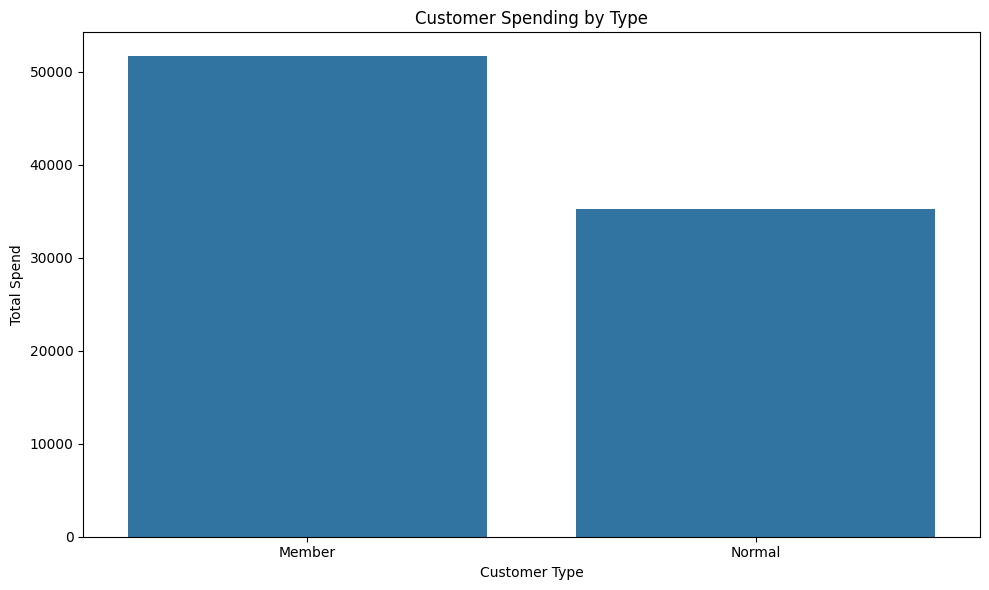

In [14]:
top_c=df.groupby('Customer Type')['Total'].sum()
top_c=top_c.sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=top_c.index,y=top_c.values)
plt.title("Customer Spending by Type")
plt.xlabel("Customer Type")
plt.ylabel("Total Spend")
plt.tight_layout()
plt.savefig("customer_spending.png")


In [16]:
import datetime as dt

df['Date'] = pd.to_datetime(df['Date'])
snapshot_date = df['Date'].max() + dt.timedelta(days=1)

rfm = df.groupby('Customer Type').agg({
    'Date': lambda x: (snapshot_date - x.max()).days,
    'Invoice ID': 'count',
    'Total': 'sum'
}).rename(columns={'Date': 'Recency', 'Invoice ID': 'Frequency', 'Total': 'Monetary'})


In [20]:

def _score_series(s, reverse=False):
    # reverse=True means smaller values are better (recency)
    ranks = s.rank(method='dense', ascending=not reverse)
    max_rank = ranks.max()
    min_rank = ranks.min()
    if max_rank == min_rank:
        # all values identical -> give a neutral middle score
        return pd.Series([3] * len(s), index=s.index)
    scaled = 1 + ((ranks - min_rank) / (max_rank - min_rank) * 4)  # scale to 1..5
    return scaled.round().astype(int)

rfm['R_Score'] = _score_series(rfm['Recency'], reverse=True)
rfm['F_Score'] = _score_series(rfm['Frequency'], reverse=False)
rfm['M_Score'] = _score_series(rfm['Monetary'], reverse=False)

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Sum'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

In [21]:
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)


In [22]:
rfm['Segment'] = pd.cut(
    rfm['RFM_Score'],
    bins=[2, 6, 9, 12, 15],
    labels=['Low Value', 'Mid Value', 'High Value', 'Top Customers']
)


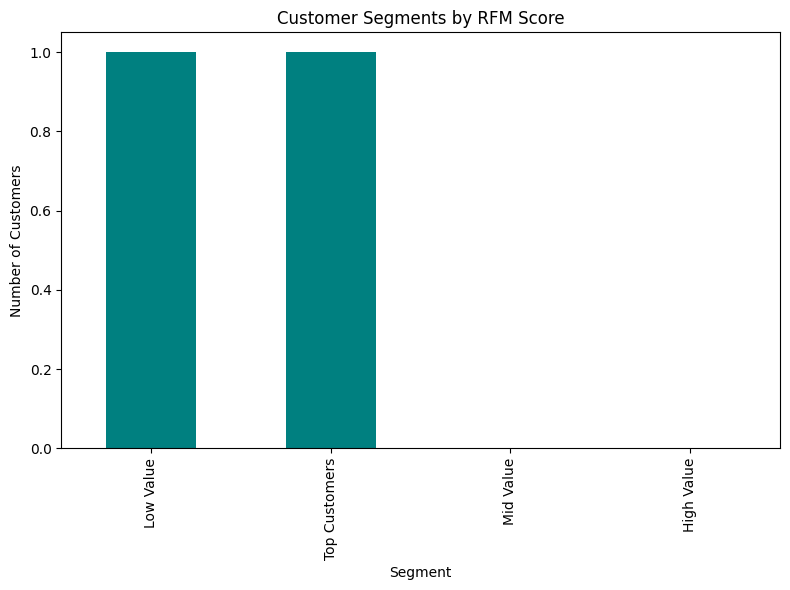

In [34]:
plt.figure(figsize=(8,6))
rfm['Segment'].value_counts().plot(kind='bar', color='teal')
plt.title('Customer Segments by RFM Score')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig("Customer segmentsby RFM score.png" )

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


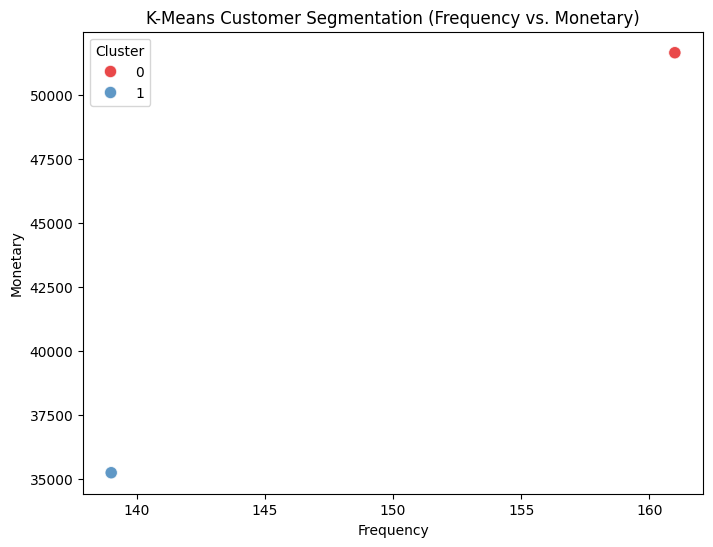

In [33]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfm['Frequency'],
    y=rfm['Monetary'],
    hue=rfm['Cluster'],
    palette='Set1',
    s=80,
    alpha=0.8
)
plt.title('K-Means Customer Segmentation (Frequency vs. Monetary)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.savefig("KMeans Customer segmntation.png")



In [32]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
Cluster,,,
0,1.0,161.0,51636.2385
1,1.0,139.0,35237.0025
